# Softmax классификатор

*Заполните этот блокнот, выполните код и защитите результаты. Полностью заполненный блокнот необходимо сохранить в электронном виде, передав его копию преподавателю, ведущему занятия. 

Это задание аналогично заданию исследования SVM классификатора.
В этом упражнении вы должны будете:

- реализовать полностью векторизованную **функцию потерь** для Sоftmax классификатора
- реализовать полностью векторизованное выражение для её **аналитического градиента**
- **проверить свою реализацию** с помощью численного градиента
- использовать валидационное множество для подбора **скорости обучения и коэффициента регуляризации**
- **оптимизировать** функцию потерь с помощью алгоритма **SGD**
- **визуализировать** окончательные обученные веса классификатора

Этот блокнот является адаптированной версией аналогичного курса [Стэнфордского университета](http://vision.stanford.edu/teaching/cs231n/index.html)


In [3]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Для перезагрузки внешних модули python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Загружает набор данных CIFAR-10 с диска и выполняет его предварительную обработку для 
    линейной классификации. Функция выполняет те же действия, которые выполнялись при
    подготовке данных для  SVM классификатора.Но все действия собраны в одной функции.
       
    """
    # Загрузка базы CIFAR-10.
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # выборка данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Предобработка: реформатирование изображений в векторы
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Нормализация данных: вычитание среднего изображения
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # добавление смещения и преобразование в столбцы
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev



# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass


# Вызов функции, определенной выше для получения данных
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax классификатор

Ваш код для этого раздела необходимо помещать в файл **cs231n/classifiers/softmax.py**. 


In [6]:
# Сначала реализуем наивную функцию потерь softmax с вложенными циклами.
# Откройте файл cs231n/classifiers/softmax.py и реализуйте функцию 
# softmax_loss_naive.



from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Создание случайной весовой матрицы и использование ее для вычисления потерь (loss).
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Проверка здравого смысла -  потери должны быть близкими к -log (0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.329127
sanity check: 2.302585


## Вопрос 1:

Почему мы ожидаем, что потери будут близки к -log (0.1)? Объясните кратко. **

**Ваш ответ:** *0.1 означает 1/10. А у нас всего 10 классов*


In [7]:
# Завершите реализацию softmax_loss_naive и реализуйте (наивную)
# версию вычисления градиента, которая использует вложенные циклы.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как и для SVM, используйте проверку числового градиента как инструмент отладки.
# Числовой градиент должен быть близок к аналитическому градиенту.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Аналогично случаю SVM, выполните еще одну проверку градиента с регуляризацией
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.158271 analytic: -2.158271, relative error: 1.868155e-08
numerical: 0.488165 analytic: 0.488165, relative error: 5.387669e-08
numerical: 3.144079 analytic: 3.144079, relative error: 9.361243e-09
numerical: -1.322869 analytic: -1.322869, relative error: 2.662538e-08
numerical: 2.845172 analytic: 2.845172, relative error: 4.621127e-09
numerical: -1.146820 analytic: -1.146820, relative error: 1.846301e-08
numerical: -1.371010 analytic: -1.371010, relative error: 2.186623e-08
numerical: 0.840260 analytic: 0.840260, relative error: 2.307562e-08
numerical: 2.714324 analytic: 2.714324, relative error: 1.588501e-09
numerical: -1.114562 analytic: -1.114562, relative error: 2.092800e-08
numerical: -0.607491 analytic: -0.607491, relative error: 7.389042e-08
numerical: 1.733801 analytic: 1.733801, relative error: 1.571870e-08
numerical: 2.625624 analytic: 2.625624, relative error: 4.155422e-08
numerical: 3.332396 analytic: 3.332396, relative error: 1.507280e-08
numerical: -0.817497 a

In [8]:
# Теперь, когда у нас есть наивная реализация функции потери softmax и ее градиента,
# реализуйте векторную версию функции softmax_loss_vectorized.
# Две версии должны вычислять одни и те же результаты, но векторизованная версия должна быть
# намного быстрее.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Как и для SVM, мы используем норму Фробениуса для сравнения двух версий
# вычисления градиента.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.329127e+00 computed in 56.207997s
vectorized loss: 2.329127e+00 computed in 0.013006s
Loss difference: 0.000000
Gradient difference: 0.000000


In [11]:
# Используйте валидационное множество для выбора гиперпараметров (коэффициента регуляризации и
# скорости обучения). Вы должны экспериментировать с различными значениями скорости обучения
# и коэффициента регуляризации; если вы будете аккуратны, то должны 
# получить точность классификации более 0,35 на валидационном множестве.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# ЗАДАНИЕ:                                                                     #
# Используйте валидационное множество, чтобы выбрать скорость обучения         #
# и коэффициент регуляризации. Это аналогично процессу валидации, который вы   #
# реализовали для SVM; сохраните лучший обученный softmax классификатор в      #
# best_softmax.                                                                #
################################################################################
def compute_accuracy(y, y_pred):
    return np.mean(y == y_pred)


for lr in learning_rates:
    for reg in regularization_strengths:
        # train softmax classifier
        print("**********************************")
        print("lr: %.7f, reg: %.1f" %(lr, reg))
        model = Softmax()
        model.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        # compute accuracy
        train_accuracy = compute_accuracy(y_train, model.predict(X_train))
        val_accuracy = compute_accuracy(y_val, model.predict(X_val))
        print('train accuracy: %.4f' %train_accuracy)
        print('validation accuracy: %.4f' %val_accuracy)

        # store accuracy in dictionary
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # check if validation accuracy is best
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = model
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################
    
# Вывод результатов
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

**********************************
lr: 0.0000001, reg: 25000.0
train accuracy: 0.3514
validation accuracy: 0.3730
**********************************
lr: 0.0000001, reg: 50000.0
train accuracy: 0.3331
validation accuracy: 0.3470
**********************************
lr: 0.0000005, reg: 25000.0
train accuracy: 0.3530
validation accuracy: 0.3690
**********************************
lr: 0.0000005, reg: 50000.0
train accuracy: 0.3352
validation accuracy: 0.3450
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.351388 val accuracy: 0.373000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.333143 val accuracy: 0.347000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.353000 val accuracy: 0.369000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.335184 val accuracy: 0.345000
best validation accuracy achieved during cross-validation: 0.373000


In [12]:
# Оценка лучшего классификатора на тестовом множестве
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.367000


**Вопрос** - *Да или нет*

Можно добавить новую точку данных в обучающее множество и это оставит SVM потери без изменений, но это не верно применительно к потерям, вычисляемым Softmax классификатором.

*Ваш ответ*: Да

*Ваши объяснения*: Разница заключается в работе самих классификаторов. В обоих случаях мы вычисляем один и тот же вектор оценки f. Однако есть различие в интерпретации этих оценок: SVM интерпретирует их как оценки класса, и его функция потерь поощряет правильный класс, чтобы его оценка была выше, чем другие оценки классов. Классификатор Softmax вместо этого интерпретирует оценки как ненормализованые логвероятности для каждого класса, а затем поощряет (нормализованную) лог-вероятность правильного класса.

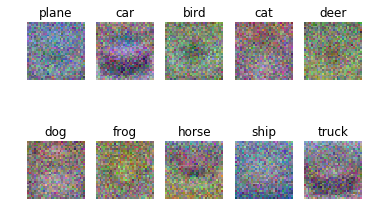

In [13]:
# Визуализация обученных весов для каждого класса.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])